# One Sided Selection

Applies CNN followed by Tomek Links to remove noisy observations from the undersampled data set.

CNN selects samples of the majority class that are more similar to those of the minority class. Thus, it is prone to introduce some noise. With Tomek Links, this procedure aims to remove that "noise".

====

- **Criteria for data exclusion**: CNN + Tomek Links
- **Final Dataset size**: varies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import OneSidedSelection

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Undersample with One Side Selection

[OneSidedSelection](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.OneSidedSelection.html)

### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up OSS

oss = OneSidedSelection(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = oss.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((730, 2), (730,))

Note that more observations have been removed compared to Tomek Links alone (tip, check previous notebook).

In [6]:
# number of minority class observations

y.value_counts()

0    983
1     17
dtype: int64

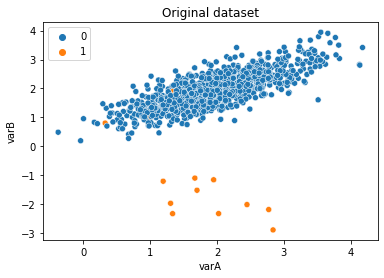

In [7]:
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Original dataset')
plt.show()

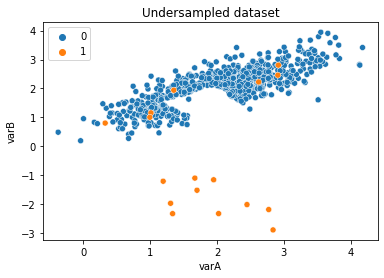

In [8]:
# plot undersampled data

sns.scatterplot(
    data=X_resampled, x="varA", y="varB", hue=y_resampled
)

plt.title('Undersampled dataset')
plt.show()

Note that missing chunk of data? Those were likely excluded by Tomek Links.

### Partially separated classes

In [9]:
# create data
X, y = make_data(sep=0.5)

# set up OSS

oss = OneSidedSelection(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = oss.fit_resample(X, y)

In [10]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# undersampled data

X_resampled.shape, y_resampled.shape

((939, 2), (939,))

Note that more samples were excluded in the final training set, compared to the previous case where classes were more separated. This is because there are more Tomek Links, as the classes are now not so separated.

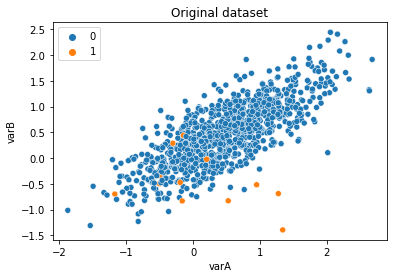

In [12]:
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Original dataset')
plt.show()

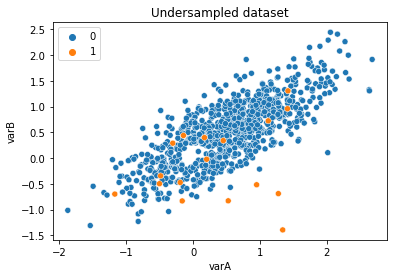

In [13]:
# plot undersampled data

sns.scatterplot(
    data=X_resampled, x="varA", y="varB", hue=y_resampled
)

plt.title('Undersampled dataset')
plt.show()

**HOMEWORK**

- Remove both observations from the Tomek Link and compare the sizes of the undersampled datasets and the distribution of the observations in the plots.
- Change the number of neighbours as well and compare the results.

===


## One Sided Selection

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [14]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
44982,60.93,24.83,0.38,27.0,58.5,2624.8,0.03,0.62,14.5,-73.5,...,2449.2,0.46,1.69,10.0,-44.0,202.9,0.69,0.11,-0.67,-1
79840,61.63,24.03,-0.38,9.5,-24.0,2548.5,-2.55,0.60,-7.5,-106.0,...,1417.6,0.85,2.91,-3.0,-94.0,469.7,1.22,0.24,0.51,-1
106302,67.13,26.04,-0.18,-61.0,4.5,1579.0,-1.33,0.35,-40.0,-65.5,...,483.5,2.23,0.23,-4.0,-70.0,533.5,0.02,-0.26,-0.99,-1
105558,39.86,38.60,0.62,-28.5,25.0,1010.2,1.11,1.75,16.0,-71.0,...,2205.2,-1.11,-1.82,-5.0,-27.0,198.2,0.84,-0.21,-1.42,-1
139796,64.47,25.24,-0.38,6.0,17.5,1464.2,0.08,0.78,5.5,-79.0,...,1360.4,0.03,0.91,10.0,-38.0,231.9,0.50,0.23,0.47,-1


In [15]:
# imbalanced target
data.target.value_counts() / len(data)

-1    0.9913
 1    0.0087
Name: target, dtype: float64

In [16]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 74), (3000, 74))

In [17]:
# this is going to take a while

# set up OSS

oss = OneSidedSelection(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = oss.fit_resample(X_train, y_train)

In [18]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((6595, 74), (6595,))

In [19]:
# number of positive class in original dataset
y_train.value_counts()

-1    6944
 1      56
Name: target, dtype: int64

## Plot data

Let's compare how the data looks before and after the undersampling.

Text(0.5, 1.0, 'Original data')

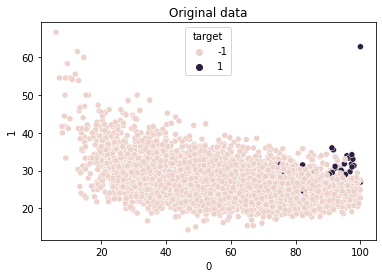

In [20]:
# original data

sns.scatterplot(data=X_train,
                x="0",
                y="1",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

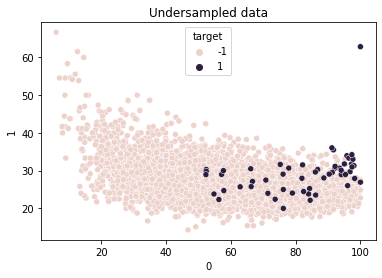

In [21]:
# undersampled data

sns.scatterplot(data=X_resampled,
                x="0",
                y="1",
                hue=y_resampled)

plt.title('Undersampled data')

Text(0.5, 1.0, 'Original data')

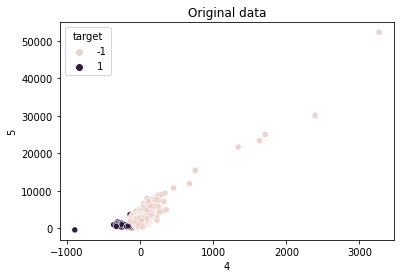

In [22]:
# original data

sns.scatterplot(data=X_train,
                x="4",
                y="5",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

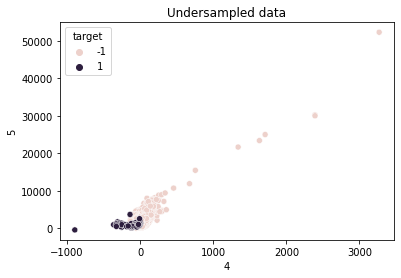

In [23]:
sns.scatterplot(data=X_resampled,
                x="4",
                y="5",
                hue=y_resampled)

plt.title('Undersampled data')

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [24]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [25]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9894538964779459
Test set
Random Forests roc-auc: 0.9838220754245484


In [26]:
# evaluate performance of algorithm built
# using undersampled dataset

run_randomForests(X_resampled,
                  X_test,
                  y_resampled,
                  y_test)

Train set
Random Forests roc-auc: 0.9871881349267034
Test set
Random Forests roc-auc: 0.9817360032160279


One Sided Selection did not seem to improve performance.

**HOMEWORK**

- Try removing both members of the Tomek Link and changing the number of neighbours. Compare final dataset size, model performance and the distributions of the observations before and after the undersampling.